In [1]:
import matplotlib
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import rcParams
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{txfonts}"
rcParams["font.family"] = 'serif'
rcParams["font.serif"] = 'Times'
rcParams["font.size"] = 16

import pandas as pd
import subprocess

In [2]:
correctiontype = 'const19'

In [3]:
# file containing parallax, parallax_error, ra, dec
df = pd.read_hdf('data/edr3int1_AC10.h5','table')
zpcode = ''

if correctiontype == 'zeropoint_file2' :
# file containing zero-point values
    df_z = pd.read_hdf('data/edr3int3_AC10_zpt2.h5','table','r')
    df = pd.merge(df_z,df,on='source_id')
    df['parallax_corrected'] = df['parallax'] - df['zpt']
    df_z =  []
    zpcode = '_zp2'
elif correctiontype == 'none' :
    df['parallax_corrected'] = df['parallax']
    zpcode = ''
elif correctiontype == 'const19' :
    df['parallax_corrected'] = df['parallax'] + 0.019
    zpcode = '_zp19'
else :
    print('No correction given, assuming none')
    df['parallax_corrected'] = df['parallax']
    zpcode = ''

In [4]:
df_prior = pd.read_csv('DistanceCode/Prior.density.tab')
parcuts = [50,20,10,5,3]
rrange = np.linspace(0,10,51)

In [5]:
import coordTransform_matrix

coords = np.array([df.ra.values, df.dec.values, np.ones_like(df.ra.values), df.pmra.values, df.pmdec.values]).T
uncerts = np.zeros_like(coords)
gc, __, __ = coordTransform_matrix.transformIcrsToGal(coords,uncerts)

df['l'] = gc[:,0]
df['b'] = gc[:,1]

In [6]:
df_good = df[df.parallax_corrected>=3.*df.parallax_error]

In [7]:
df_good.to_csv('DistanceCode/edr3int3/Distances_REAL'+zpcode+'.input',sep=' ',
               columns=['source_id', 'l','b','parallax_corrected','parallax_error'], 
              index=False, header=False)

.....

/Users/mcmillan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/mcmillan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


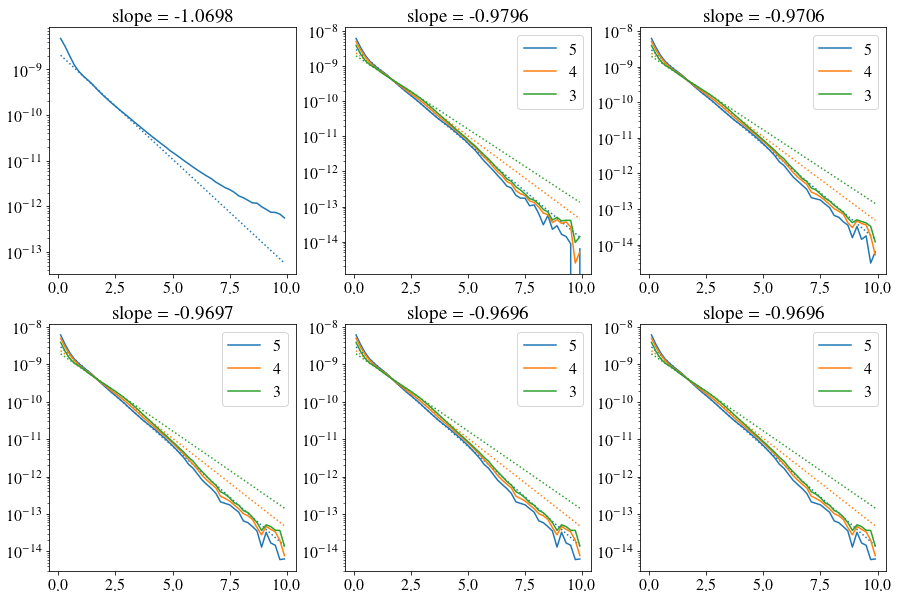

In [8]:

nIterations = 5
runDistanceCode=True

plt.gcf().set_size_inches(15,10)
plt.subplot(2,3,1)
maskP = df_good['parallax_corrected']/df_good['parallax_error'] > 3

hist,bin_edges = np.histogram(1./(df_good['parallax'])[maskP],rrange,density=True)
rcentres = 0.5*( bin_edges[:-1]+bin_edges[1:] )

maskdist = (rcentres< 3.) & (rcentres>1.)
color = 0
plt.plot(rcentres,hist/df_prior.integrated_prior.values,
         color='C%d' % color)
slope, intercept, _, _, _ = stats.linregress(rcentres[maskdist],
                                            np.log(hist[maskdist]
                                                   /df_prior.integrated_prior[maskdist]))
#print(hist[maskdist])
plt.plot(rcentres,np.exp(intercept+slope*rcentres),linestyle=':',color='C%d' % color)

#plt.legend(fontsize='x-small')
plt.yscale('log')
plt.title('slope = %.4f' % slope)

for i in range (nIterations) : 
    plt.subplot(2,3,i+2)
    outname = 'DistanceCode/edr3int3/Distances_REAL'+zpcode+'.out%d' % (i+1)
    #outname = 'DistanceCode/Distances_GOGUM.out%d' % (i+1)
    if runDistanceCode :
        Runcode = subprocess.run(["DistanceCode/Distance_calc_anticentre.exe", 
                                  'DistanceCode/edr3int3/Distances_REAL'+zpcode+'.input',
                                  outname,
                                 '%f' % slope])
    print ('.',end='')
    
    #df_tmp = pd.read_hdf_tmp('GOGUM_AC10_sample.h5', 'table')
    df_tmp_out = pd.read_csv(outname)
    df_tmp = pd.merge(df_good,df_tmp_out,on='source_id')
    parcuts = [5,4,3]
    rrange = np.linspace(0,10,51)

    color = 0
    for pc in parcuts :
        testmask = df_tmp['parallax_corrected']/df_tmp['parallax_error'] > pc
        hist,bin_edges = np.histogram((df_tmp['distance'])[testmask],rrange,density=True)
        rcentres = 0.5*( bin_edges[:-1]+bin_edges[1:] )
        
        maskdist = (rcentres< 3.) & (rcentres>1.)
        plt.plot(rcentres,hist/df_prior.integrated_prior.values,
                label='%d' % pc,color='C%d' % color)
        slope, intercept,  _, _, _  = stats.linregress(rcentres[maskdist],
                                                        np.log(hist[maskdist]
                                                            /df_prior.integrated_prior[maskdist]))
        plt.plot(rcentres,np.exp(intercept+slope*rcentres),linestyle=':',color='C%d' % color)
        color+=1
        #print(pc,slope)
    plt.yscale('log')
    plt.legend()
    plt.title('slope = %.4f' % slope)

plt.show()

In [9]:
df_write = pd.read_csv('DistanceCode/edr3int3/Distances_REAL'+zpcode+'.out5')


In [10]:

df_write.to_csv('DistanceCode/edr3int3/edr3int3_AC10'+zpcode+'_piepi3_BD_PM.csv')
df_write.to_hdf('DistanceCode/edr3int3/edr3int3_AC10'+zpcode+'_piepi3_BD_PM.h5','table')


In [11]:
df_write

,source_id,distance,distance_error
0,190910338532771072,1.215330,0.103126
1,187475906589468032,0.865153,0.553840
2,190734962132211200,1.421710,0.307142
3,161110962078834560,1.871210,0.601974
4,187072969937192320,4.921700,0.789203
...,...,...,...
3644565,3382851585340895104,0.208570,0.004487
3644566,3376657525242622976,1.047130,0.144785
3644567,3375184141002786944,1.525070,0.354228
3644568,3382509985119331840,1.668530,0.088790


In [12]:
dfzp2 = pd.read_hdf('DistanceCode/edr3int3/edr3int3_AC10_zpt2_piepi3_BD_PM.h5','table')

In [13]:
dfboth = pd.merge(df_write,dfzp2,on='source_id')

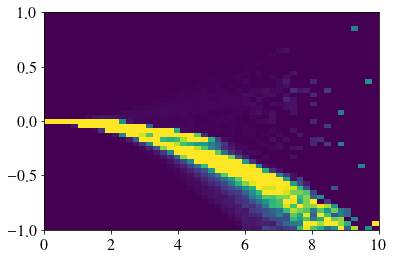

In [34]:
N2, xedge,yedge = np.histogram2d(dfboth.distance_x,dfboth.distance_y-dfboth.distance_x,
                                 bins=[np.linspace(0,10),np.linspace(-1,1)])
N,_ = np.histogram(dfboth.distance_x,np.linspace(0,10))
N2tmp = N2/N[:,None]
plt.pcolormesh(xedge,yedge,N2tmp.T,vmax=0.1)
plt.show()

In [32]:
np.sum(N)

3642921

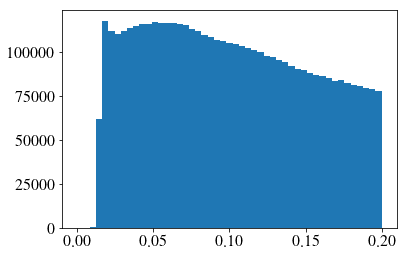

In [35]:
plt.hist(df.parallax_error,np.linspace(0,0.2))
plt.show()